---
title: Lab 7 
author: Marvin (Wenxiang) Li
format:
    html:
        toc: true
        code-fold: true
embed-resources: true
---

In [114]:
import numpy as np
import pandas as pd
HeartAttack = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
HeartAttack.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [115]:
missing_values = HeartAttack.isnull().sum()
missing_values

age        0
sex        0
cp         0
trtbps     0
chol       0
restecg    0
thalach    0
output     0
dtype: int64

## Part Zero: Data Exploration

In [116]:
import plotnine as p9

- plot y to see if they are imbalanced

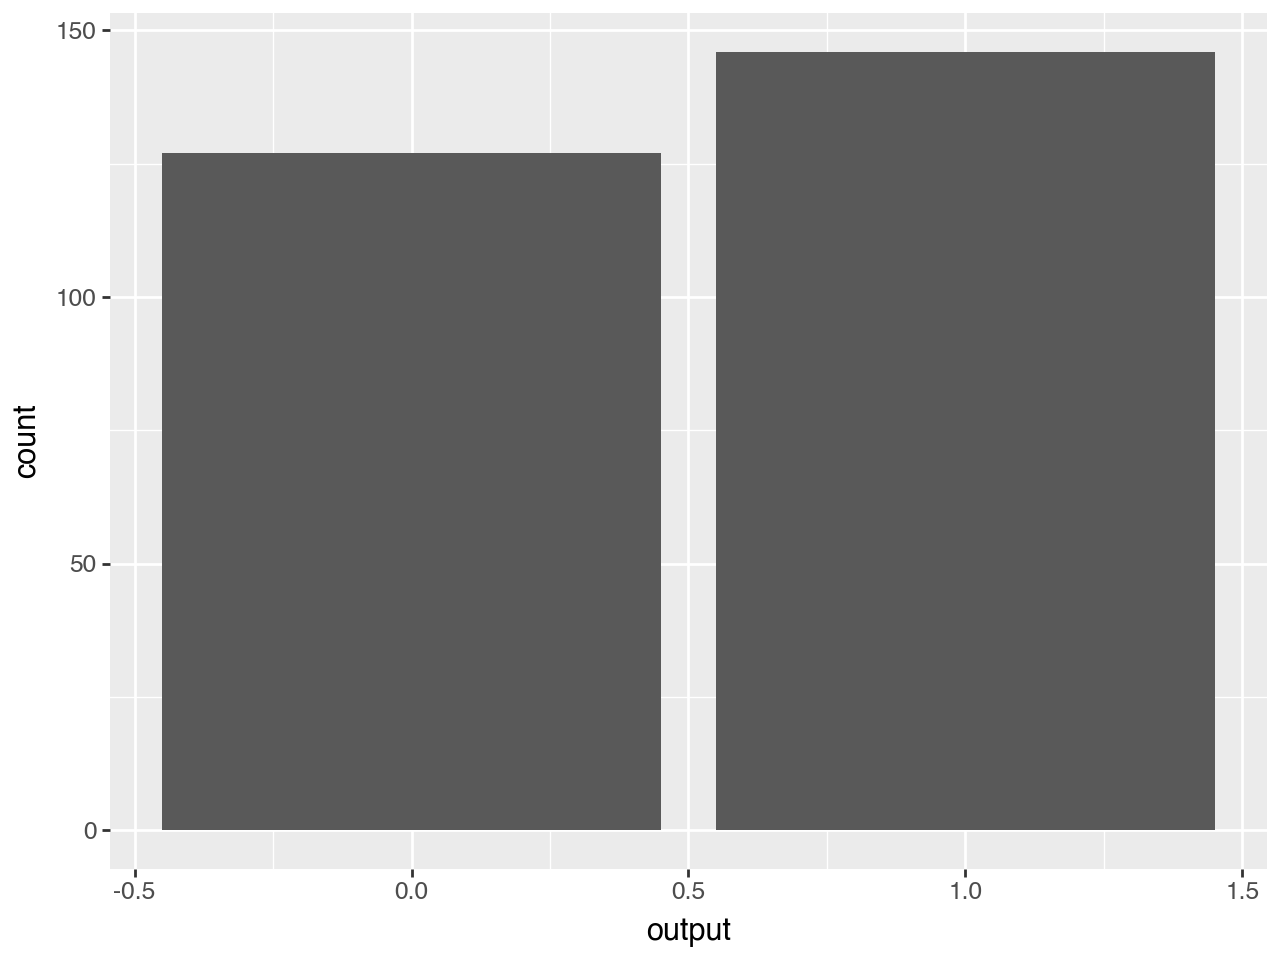

In [117]:
(p9.ggplot(data=HeartAttack)+
 p9.aes(x = 'output')+
 p9.geom_bar())

Distribution of y is not imbalanced

- Correlation matrix
- There are some collinearity between predictors

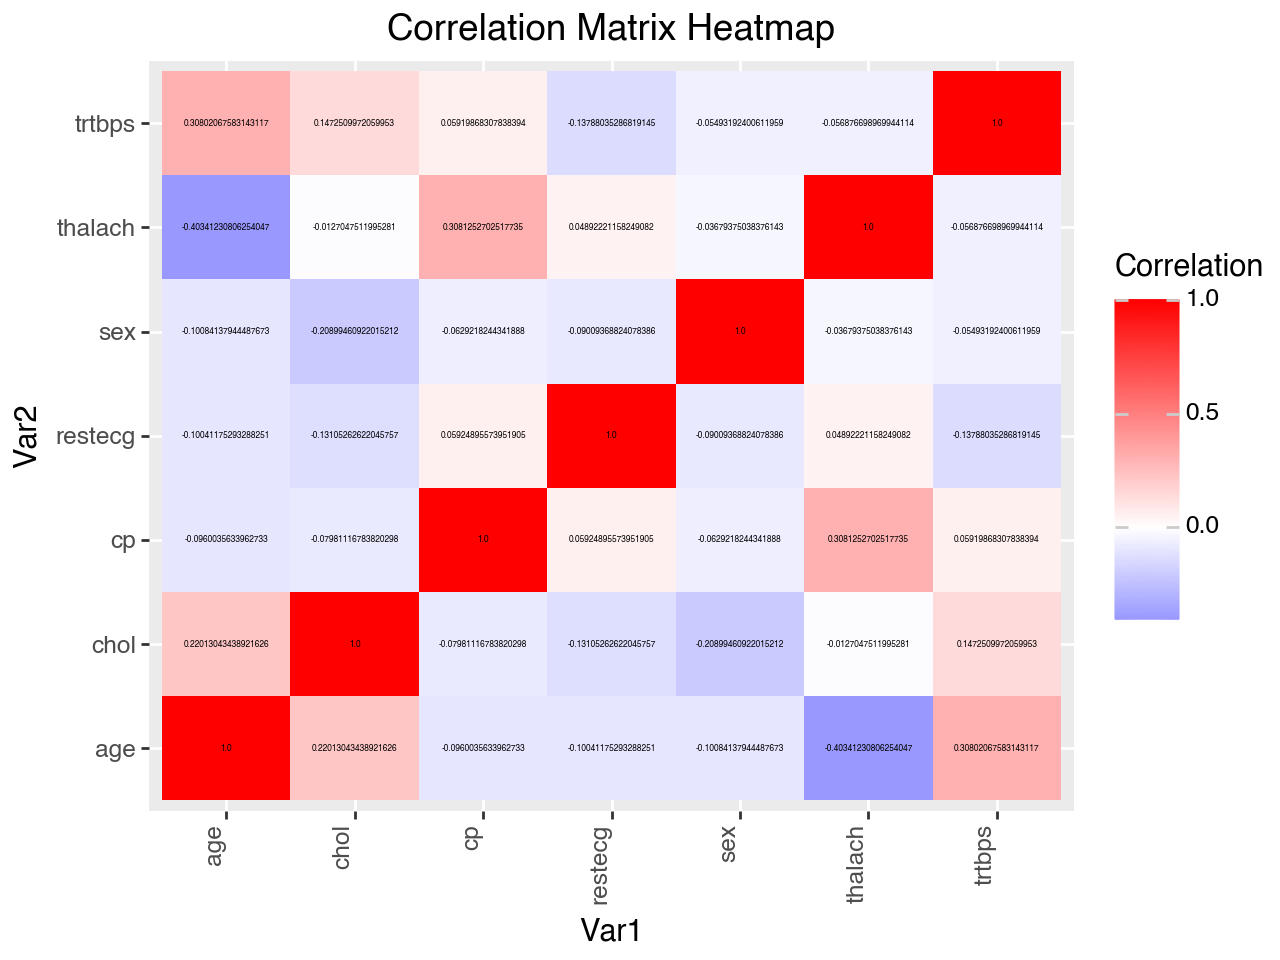

In [118]:
X = HeartAttack.drop("output", axis = 1)
correlation_matrix = X.corr().reset_index()
# Convert the correlation matrix into long format
corr_long = correlation_matrix.melt(id_vars='index')
corr_long.columns = ['Var1', 'Var2', 'Correlation'] 
(p9.ggplot(corr_long) +
p9.aes(x='Var1', y='Var2', fill='Correlation') +
p9.geom_tile() +
p9.geom_text(p9.aes(label='Correlation'), color='black', size=3) +  # Add correlation labels
p9.scale_fill_gradient2(low='blue', high='red', mid='white', midpoint=0) +  # Color scale
p9.theme(axis_text_x=p9.element_text(rotation=90, hjust=1),  # Rotate x-axis labels
axis_text_y=p9.element_text(rotation=0, hjust=1)) +  # Rotate y-axis labels
p9.labs(title='Correlation Matrix Heatmap')
)

In [119]:
X = HeartAttack.drop("output", axis = 1)
y = HeartAttack["output"]

## Part I: Fitting Models

In [120]:
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

### 1. KNN

In [121]:
from sklearn.neighbors import KNeighborsClassifier

- make a function for all models

In [122]:
def model_try(scaler, classifier, num, cat):
  ct = ColumnTransformer(
    [ ("num", StandardScaler(), num),
      ("cat", "passthrough", cat)
    ],
    remainder = "drop"
    )
  ct2 = ColumnTransformer(
    [ ("num", "passthrough", num),
      ("cat", "passthrough", cat)
    ],
    remainder = "drop"
    )
  if scaler == 'Yes':
    steps = [("preprocessing", ct), ('classifier', classifier)]
  if scaler == 'No':
    steps = [("preprocessing", ct2), ('classifier', classifier)]
  model = Pipeline(steps)
  return model     

In [123]:
num1 = ["age", "chol", "trtbps", "thalach"]  
cat1 = ["sex", "cp", "restecg"] 
model_1 = model_try('Yes', KNeighborsClassifier(), num1, cat1)


- k is usually picked using sqrt(n); + 5 because score increases after 16

In [124]:
param_grid1 = {
    'classifier__n_neighbors': range(14, 21),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['manhattan', 'euclidean']
}
search_1 = GridSearchCV(model_1, param_grid1, cv=5, scoring='roc_auc')
search_1_fitted = search_1.fit(X, y)


In [125]:
result_1 = pd.DataFrame(data = {"metric":  search_1.cv_results_['param_classifier__metric'], 
                            "n_neighbors": search_1.cv_results_['param_classifier__n_neighbors'],
                            "weights": search_1.cv_results_['param_classifier__weights'],
                            "mean_roc_auc": search_1.cv_results_['mean_test_score']}
                            ).sort_values(by = "mean_roc_auc", ascending = False)
result_1.head(3)

,metric,n_neighbors,weights,mean_roc_auc
12,manhattan,20,uniform,0.834005
9,manhattan,18,distance,0.832240
13,manhattan,20,distance,0.831931


In [126]:
model_1_selected = model_try('Yes', KNeighborsClassifier(metric = 'manhattan', n_neighbors = 20, weights = 'uniform'),
                             num1, cat1)
y_pred1 = cross_val_predict(model_1_selected, X, y, cv=5)
conf_matrix_1 = confusion_matrix(y, y_pred1, labels=y.unique())
conf_matrix_df1 = pd.DataFrame(conf_matrix_1, index=y.unique(), columns=y.unique())
conf_matrix_df1.index.name = "Actual"
conf_matrix_df1.columns.name = "Predicted"
conf_matrix_df1

Predicted,1,0
Actual,,
1,109,37
0,27,100


### 2. Logistic Regression

In [127]:
import statsmodels.api as sm

In [128]:
num2 = ["age", "chol", "trtbps", "thalach"]  
cat2 = ["sex", "cp", "restecg"] 
model_2 = model_try('Yes', LogisticRegression(), num2, cat2)

In [129]:
param_grid2 = {
    'classifier__penalty': ['elasticnet'],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['saga'],
    'classifier__l1_ratio': [0, 0.25, 0.5, 1],  # Only for 'elasticnet' penalty
    'classifier__max_iter': [100000000],
}
search_2 = GridSearchCV(model_2, param_grid2, cv=5, scoring='roc_auc')
search_2_fitted = search_2.fit(X, y)

In [130]:
result_2 = pd.DataFrame(data = { "C": search_2.cv_results_['param_classifier__C'],
                            "l1_ratio": search_2.cv_results_['param_classifier__l1_ratio'],
                            "mean_roc_auc": search_2.cv_results_['mean_test_score']}
                            ).sort_values(by = "mean_roc_auc", ascending = False)
result_2.head(3)

,C,l1_ratio,mean_roc_auc
11,1,1,0.855455
10,1,0.5,0.855444
9,1,0.25,0.855443


In [131]:
model_2_selected = model_try('Yes', LogisticRegression(penalty='elasticnet', 
                                                         C = 1, 
                                                         solver = 'saga',
                                                         l1_ratio =1,
                                                         max_iter = 100000000
                                                         ), num2, cat2)
y_pred2 = cross_val_predict(model_2_selected, X, y, cv=5)
conf_matrix_2 = confusion_matrix(y, y_pred2, labels=y.unique())
conf_matrix_df2 = pd.DataFrame(conf_matrix_2, index=y.unique(), columns=y.unique())
conf_matrix_df2.index.name = "Actual"
conf_matrix_df2.columns.name = "Predicted"
conf_matrix_df2

Predicted,1,0
Actual,,
1,120,26
0,32,95


In [132]:
model_2_fitted = model_2.fit(X, y)
# Extract coefficients and intercept
coef2 = model_2_fitted.named_steps['classifier'].coef_
coef2 = coef2 .flatten()
coef2

array([-0.23078045, -0.2418374 , -0.37282133,  0.85443465, -1.83957324,
        0.82364889,  0.30613728])

In [133]:
numerical_features = ["age", "chol", "trtbps", "thalach"]  
categorical_features = ["sex", "cp", "restecg"] 
ct = ColumnTransformer(
    [ ("num", StandardScaler(), numerical_features),
      ("cat", "passthrough", categorical_features)
    ],
    remainder = "drop"
    )
feature_names = ct.fit(X).get_feature_names_out()
feature_names
df_coef2 = pd.DataFrame({'Feature': feature_names, 'Logistc': coef2})
df_coef2.sort_values(by = 'Logistc', ascending = False)



,Feature,Logistc
3,num__thalach,0.854435
5,cat__cp,0.823649
6,cat__restecg,0.306137
0,num__age,-0.230780
1,num__chol,-0.241837
2,num__trtbps,-0.372821
4,cat__sex,-1.839573


In [134]:
logit_model = sm.Logit(y, sm.add_constant(X))
result = logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.456935
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 output   No. Observations:                  273
Model:                          Logit   Df Residuals:                      265
Method:                           MLE   Df Model:                            7
Date:                Fri, 22 Nov 2024   Pseudo R-squ.:                  0.3385
Time:                        15:49:27   Log-Likelihood:                -124.74
converged:                       True   LL-Null:                       -188.57
Covariance Type:            nonrobust   LLR p-value:                 1.947e-24
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5093      2.105      0.242      0.809      -3.616       4.635
age           -0.0266      0.

- if a patient report value 1 chest pain, on average, there is 69.5% chance this patient would be diagnosed as at risk.


In [135]:
log_odd1 = 0.823649
1/(1 + np.exp(-log_odd1))

0.6950103720587916

- as max heart rate during exercise is 23 above the mean, the probability of being diagnosed at risk will be 70%. If it increase from 23 to 46 above the mean, the probability will be 14.5% higher than 23 above the mean.

In [136]:
X['thalach'].mean()

149.44688644688645

In [137]:
X['thalach'].std()

23.240706543429212

In [138]:
log_odd2 = 0.854435
y2 = 1 / (1 + np.exp(-log_odd2))
y2

0.701496656596124

In [139]:

log_odd3 = 0.854435 * 2
y3 = 1 / (1 + np.exp(-log_odd3))
y3 - y2

0.14519300400003188

- intercept

In [140]:
intercept = model_2_fitted.named_steps['classifier'].intercept_
intercept

array([0.47240331])

### 3. Decision Tree

In [141]:
num3 = ["age", "trtbps", "thalach"]  
cat3 = ['sex','cp'] 
model_3 = model_try("No", DecisionTreeClassifier(random_state= 42), num3, cat3)

In [145]:
param_grid3 = {
    'classifier__min_impurity_decrease': [0.001, 0.01, 0.05, 0.1],
    'classifier__max_depth': [2, 5, 10, 15, None],
    'classifier__max_features': [None, 'sqrt', 3, 4],
    'classifier__ccp_alpha': [0, 0.001, 0.01, 0.1, 0.2],
}
search_3 = GridSearchCV(model_3, param_grid3, cv=5, scoring='roc_auc')
search_3_fitted = search_3.fit(X, y)

In [146]:
result_3 = pd.DataFrame(data = {"min_impurity_decrease":  search_3.cv_results_['param_classifier__min_impurity_decrease'], 
                            "max_depth": search_3.cv_results_['param_classifier__max_depth'],
                            "max_features": search_3.cv_results_['param_classifier__max_features'],
                            "ccp_alpha": search_3.cv_results_['param_classifier__ccp_alpha'],
                            "mean_roc_auc": search_3.cv_results_['mean_test_score']}
                            ).sort_values(by = "mean_roc_auc", ascending = False)
result_3.head(3)

,min_impurity_decrease,max_depth,max_features,ccp_alpha,mean_roc_auc
212,0.001,15,sqrt,0.01,0.817325
228,0.001,None,sqrt,0.01,0.817325
196,0.001,10,sqrt,0.01,0.817325


In [ ]:
model_3_selected = model_try("No", DecisionTreeClassifier(min_impurity_decrease= 0.001, 
                                                         max_depth = 15, 
                                                         max_features = 'sqrt',
                                                         ccp_alpha = 0.01,
                                                         random_state = 42
                                                         ), num3, cat3)
y_pred3 = cross_val_predict(model_3_selected, X, y, cv=5)
conf_matrix_3 = confusion_matrix(y, y_pred3, labels=y.unique())
conf_matrix_df3 = pd.DataFrame(conf_matrix_3, index=y.unique(), columns=y.unique())
conf_matrix_df3.index.name = "Actual"
conf_matrix_df3.columns.name = "Predicted"
conf_matrix_df3

Predicted,1,0
Actual,,
1,109,37
0,28,99


### 4. Interpretation

#### 1. KNN 
- In the KNN model, all Xs were put in the pipeline individually. 'cp' has the highest roc_auc score of 0.75.
- 'thalach' is the seccond highest with 0.72.
#### 2. Logistic Regresion
- Similar to KNN models, 'cp' and 'thalach' have the highest predictability of 0.74 and 0.73 roc_auc score respectively.
#### 3. Decision Tree
- Having too much categorical variables actually reduces the model's performance. The highest score occurs when 'restecg' is excluded.
- 'chol' adds a very little predictability

### 5. ROC Curve

In [ ]:
risk = (y ==1)
risk.head()

0    True
1    True
2    True
3    True
4    True
Name: output, dtype: bool

In [ ]:
y_probs_1 = cross_val_predict(model_1_selected, X, risk, cv=5, method='predict_proba')[:, 1]  # probability for positive class
y_probs_2 = cross_val_predict(model_2_selected, X, risk, cv=5, method='predict_proba')[:, 1]
y_probs_3 = cross_val_predict(model_3_selected, X, risk, cv=5, method='predict_proba')[:, 1]
fpr_1, tpr_1, _ = roc_curve(risk, y_probs_1)
fpr_2, tpr_2, _ = roc_curve(risk, y_probs_2)
fpr_3, tpr_3, _ = roc_curve(risk, y_probs_3)

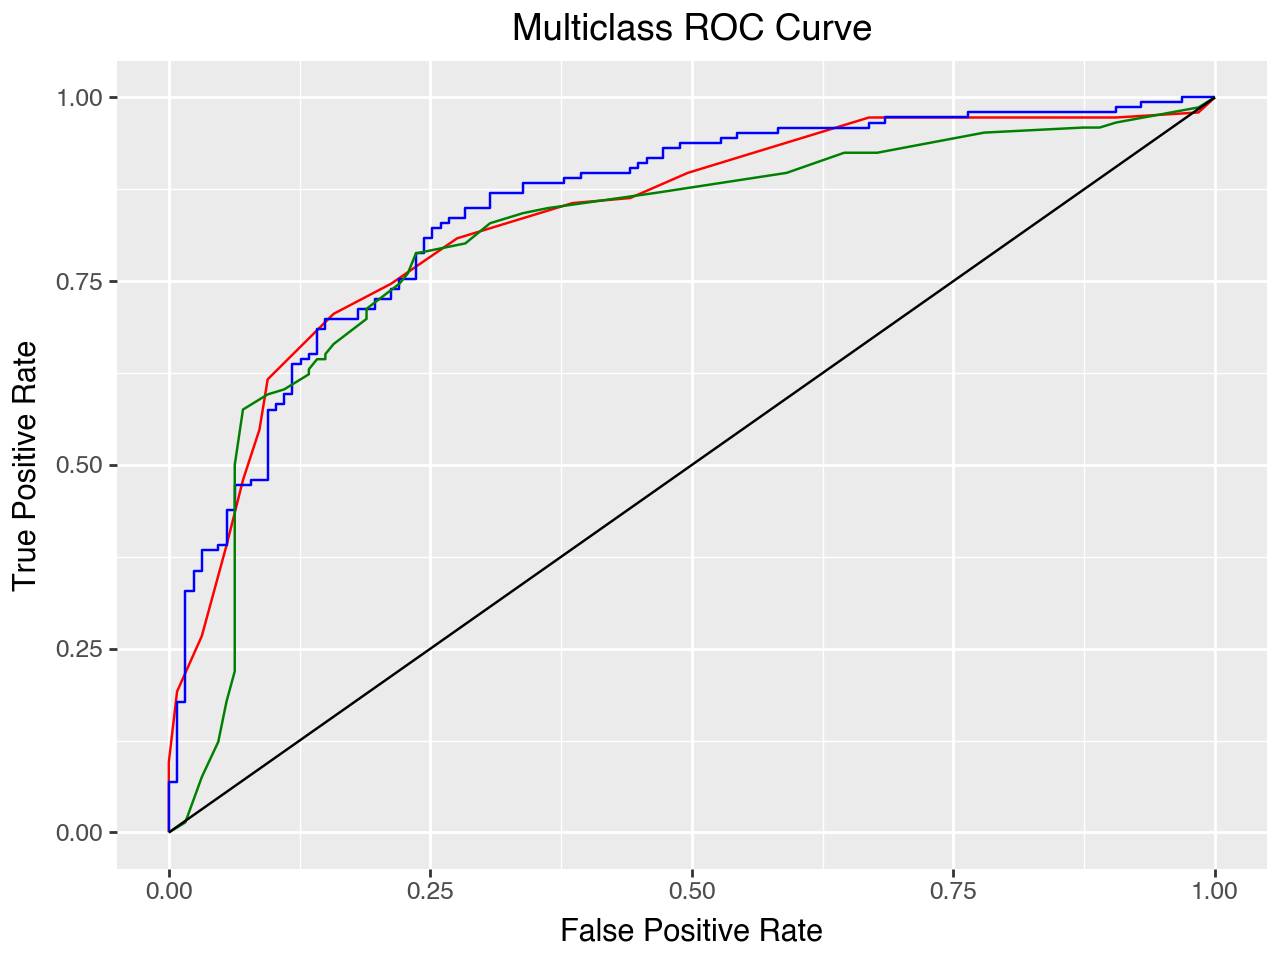

In [ ]:
linex = np.linspace(0, 1, 100)
liney = np.linspace(0, 1, 100)
(p9.ggplot(p9.aes(x=1, y=1)) +
p9.geom_line(p9.aes(x=fpr_1, y = tpr_1), color = 'red') +
p9.geom_line(p9.aes(x=fpr_2, y = tpr_2), color = 'blue') +
p9.geom_line(p9.aes(x=fpr_3, y = tpr_3), color = 'green') +
p9.geom_line(p9.aes(x=linex, y = liney), color = 'black') +
p9.labs(title='Multiclass ROC Curve', x='False Positive Rate', y='True Positive Rate')
)

## Part Two: Metrics

In [ ]:
target_names = np.array(['at risk', 'not at risk'])

### 1. KNN

In [ ]:
report1 = classification_report(y, y_pred1, target_names = target_names)
print(report1)

              precision    recall  f1-score   support

     at risk       0.73      0.79      0.76       127
 not at risk       0.80      0.75      0.77       146

    accuracy                           0.77       273
   macro avg       0.77      0.77      0.77       273
weighted avg       0.77      0.77      0.77       273



### 2. Logistic Regression

In [ ]:
report2 = classification_report(y, y_pred2, target_names = target_names)
print(report2)

              precision    recall  f1-score   support

     at risk       0.79      0.75      0.77       127
 not at risk       0.79      0.82      0.81       146

    accuracy                           0.79       273
   macro avg       0.79      0.78      0.79       273
weighted avg       0.79      0.79      0.79       273



### 3. Decision Tree

In [ ]:
report3 = classification_report(y, y_pred3, target_names = target_names)
print(report3)

              precision    recall  f1-score   support

     at risk       0.73      0.78      0.75       127
 not at risk       0.80      0.75      0.77       146

    accuracy                           0.76       273
   macro avg       0.76      0.76      0.76       273
weighted avg       0.76      0.76      0.76       273



## Part Three: Discussion

### Q1 The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack.
- In this case, the hospital wants to minimize false negative rate to avoid miss labeling people as "not at risk". Therefore, we want recall of "at risk" to be high, so the hospital will less likely to send at risk patient home. The KNN model has the highest recall rate of 0.79.
- The precision rate of the KNN model is 0.73 which is a reasonable score. F1 score is 0.76 which suggests the model has a relatively good balance between recall and precision. 

### Q2 The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk.
- In this case, the hospital wants to minimize false positive to only use space for patients most in need. We want precision of at risk to be high, so that patients who are labled "at risk" is indeed at risk. The logistic regression model has the highest precision of 0.79. 
- The recall rate of the same model is a resonable 0.75. F1 score is 0.77 suggesting a good balance. 

### Q3 The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk.
- I would recommand using the logistic regression model since it provides a list of coefficients by their absolute value for the doctors to consider. 
- Score in this case is not comparable since only logistic model has coefficients. The F1 score is 0.77, and accuracy is 0.79. They are reasonable. 

### Q4 The hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients.
- I would recommand using the decision tree model since it mimics human decision making process. The leaves and nodes can be printed out to compare with doctors' decision process. This is better than logistic model which can only show a list of coefficient rather than a dignose process. 
- The F1 score is 0.75 and accuracy is 0.76

## Part Four: Validation

In [ ]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [158]:
X2 = ha_validation.drop("output", axis = 1)
y2 = ha_validation["output"]

In [165]:
risk2 = (y2 ==1)
risk2

0      True
1      True
2      True
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10     True
11     True
12     True
13     True
14     True
15     True
16     True
17     True
18     True
19    False
20    False
21    False
22    False
23    False
24    False
25    False
26    False
27    False
28    False
29    False
Name: output, dtype: bool

In [166]:
test_proba_1 = search_1_fitted.predict_proba(X2)[:,1]
test_proba_2 = search_2_fitted.predict_proba(X2)[:,1]
test_proba_3 = search_3_fitted.predict_proba(X2)[:,1]

In [167]:
auc_1 = roc_auc_score(risk2, test_proba_1)
auc_2 = roc_auc_score(risk2, test_proba_1)
auc_3 = roc_auc_score(risk2, test_proba_1)
print([auc_1, auc_2, auc_3])

[0.9354066985645932, 0.9354066985645932, 0.9354066985645932]


In [ ]:
vali_report1 = classification_report(y, y_pred3, target_names = target_names)
print(vali_report1)

In [ ]:
vali_report2 = classification_report(y, y_pred3, target_names = target_names)
print(vali_report2)

In [ ]:
vali_report3 = classification_report(y, y_pred3, target_names = target_names)
print(vali_report3)

## Part Five: Cohen's Kappa